# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Задачи курсового проекта:

1. Загрузить и проанализировать данные.
2. Обработать данные (избавиться от пропусков, обработать выбросы и аномалии, и т.д).
3. После подготовки данных, протестировать 3 модели и выбрать наиболее подходящую под мои данные и цели.
4. На выбранной и обученной модели предсказать цены на квартиры из файла test, предварительно их обработав.

# Описание датасета
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score as r2

import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
matplotlib.rcParams.update({'font.size': 9})

In [3]:
# Функция для построения графиков и визуализации результатов.
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print('Train R2:\t' + str(round(r2(train_true_values, train_pred_values), 3)))
    print('Test R2:\t' + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    plt.show()

In [4]:
#Импортируем файлы с которыми будем работать.

train_df = pd.read_csv('C://Users//User//Desktop//train.csv')
test_df = pd.read_csv('C://Users//User//Desktop//test.csv')

# Знакомство с df

In [5]:
# Смотрю информацию по df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [6]:
train_df.shape[1]

20

In [7]:
test_df.shape[1]

19

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [9]:
# Сравниваю колличество признаков в df, а -1 , т.к. в test.csv нет цены.
train_df.shape[1]-1 == test_df.shape[1]

True

In [10]:
# Меняю тип данных
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)

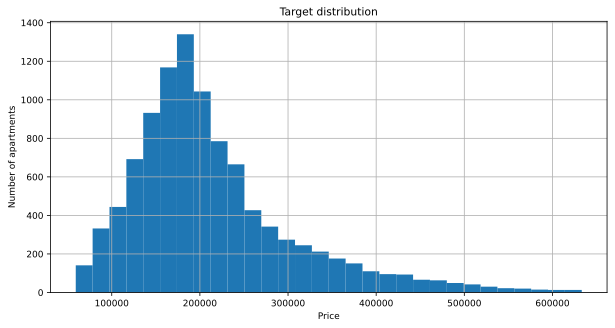

In [11]:
# Оцениваем распределение целевого признака Price

plt.figure(figsize = (10, 5))

train_df['Price'].hist(bins=30)
plt.ylabel('Number of apartments')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [12]:
# Рассматриваю количественные признаки 
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315775    37.199645       6.273300      8.526700   
std        0.839512     21.058732    86.241209      28.560917      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774881    22.769832       1.000000      4.000000   
50%        2.000000     52.513310    32.781260       6.000000      7.000000   
75%        2.000000     65.900625    45.128803       9.000000     12.000000   
max       19.000000    641.065193  7480.592129    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904460      1.319500      4.231300  214138.857399  
std       23.831875   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000   1548.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

# Обработка аномалий в комнатах


In [13]:
# Рассматривая количественные признаки я обратила внимание на квартиры с 0 комнат.
train_df[train_df['Rooms'] == 0] #Просматриваем информацию по квартирам с 0 комнат.

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1397  12638         27    0.0  138.427694  136.215499            0.0      4   
1981   7917         27    0.0  212.932361  211.231125            0.0      2   
2269   7317         27    0.0   41.790881         NaN            0.0     13   
3911    770         28    0.0   49.483501         NaN            0.0     16   
4366    456          6    0.0   81.491446         NaN            0.0      4   
4853   3224         27    0.0    2.377248    0.873147            0.0      1   
6149   3159         88    0.0   38.697117   19.345131            9.0      9   
8834   9443         27    0.0   87.762616   85.125471            0.0      5   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1397           3       2016   0.075424         B         B        11   
1981           3       2008   0.211401         B         B         9   
2269           0       1977   0.211401         B         B         9   
3911           0       2015   0.118537         B         B        30   
4366           0       1977   0.243205         B         B         5   
4853           0       1977   0.017647         B         B         2   
6149          16       1982   0.127376         B         B        43   
8834          15       1977   0.211401         B         B         9   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1397      3097         0           NaN            0        0       B   
1981      1892         0           NaN            0        1       B   
2269      1892         0           NaN            0        1       B   
3911      6207         1        1183.0            1        0       B   
4366      1564         0         540.0            0        0       B   
4853       469         0           NaN            0        0       B   
6149      8429         3           NaN            3        9       B   
8834      1892         0           NaN            0        1       B   

              Price  
1397  268394.744389  
1981  302211.260887  
2269   98129.976788  
3911  217009.338463  
4366  212864.799112  
4853  126596.941798  
6149  158998.110646  
8834  219281.918007

In [14]:
# В данных я обнаружила 2е аномалии, которые решила заменить на среднее значение
train_df.iloc[1981, 3], train_df.iloc[4853, 3] = train_df[train_df['Rooms'] == 0]['Square'].mean(),\
train_df[train_df['Rooms'] == 0]['Square'].mean()
train_df[train_df['Rooms'] == 0]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1397  12638         27    0.0  138.427694  136.215499            0.0      4   
1981   7917         27    0.0   81.620358  211.231125            0.0      2   
2269   7317         27    0.0   41.790881         NaN            0.0     13   
3911    770         28    0.0   49.483501         NaN            0.0     16   
4366    456          6    0.0   81.491446         NaN            0.0      4   
4853   3224         27    0.0   81.620358    0.873147            0.0      1   
6149   3159         88    0.0   38.697117   19.345131            9.0      9   
8834   9443         27    0.0   87.762616   85.125471            0.0      5   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1397           3       2016   0.075424         B         B        11   
1981           3       2008   0.211401         B         B         9   
2269           0       1977   0.211401         B         B         9   
3911           0       2015   0.118537         B         B        30   
4366           0       1977   0.243205         B         B         5   
4853           0       1977   0.017647         B         B         2   
6149          16       1982   0.127376         B         B        43   
8834          15       1977   0.211401         B         B         9   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1397      3097         0           NaN            0        0       B   
1981      1892         0           NaN            0        1       B   
2269      1892         0           NaN            0        1       B   
3911      6207         1        1183.0            1        0       B   
4366      1564         0         540.0            0        0       B   
4853       469         0           NaN            0        0       B   
6149      8429         3           NaN            3        9       B   
8834      1892         0           NaN            0        1       B   

              Price  
1397  268394.744389  
1981  302211.260887  
2269   98129.976788  
3911  217009.338463  
4366  212864.799112  
4853  126596.941798  
6149  158998.110646  
8834  219281.918007

In [15]:
# Также хочу рассмотреть уникальные значения по комната и проверить нет ли там выбросов.
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [16]:
# Обрабатываем отдельные аномалии в количестве комнат
# В этом случае, у квартир суммарный метраж равен примерно 60, жилой 36-38, но 10 комнат
# Соответственно, каждая комната чуть меньше 4 метров, что очень странно, поэтому заменим на среднее кол-во комнат для подобного метража
train_df.loc[train_df['Rooms'] == 10, 'Rooms'] = int(train_df.loc[(train_df['Square'].between(55,65,inclusive=True)), 'Rooms'].mean())
train_df.iloc[[377,8849]]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
377    5927         57    2.0  59.056975   36.223072           10.0     22   
8849  14865          9    2.0  60.871266   38.420681           10.0      3   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
377           22       2002   0.090799         B         B        74   
8849           2       1994   0.161532         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
377      19083         2           NaN            5       15       B   
8849      5648         1          30.0            2        4       B   

              Price  
377   317265.323792  
8849  172329.270863

In [17]:
train_df.loc[train_df['Rooms'] == 19]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1454  8491          1   19.0  42.006046   21.779288            7.0     17   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1454          17       2014   0.007122         B         B         1   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1454       264         0           NaN            0        1       B   

             Price  
1454  78364.616704

In [18]:
# Делаю то же самое, что и с 10-комнатными квартирами
train_df.loc[train_df['Rooms'] == 19, 'Rooms'] = int(train_df.loc[(train_df['Square'].between(40,45,inclusive=True)), 'Rooms'].mean())
train_df.iloc[1454]

Id                       8491
DistrictId                  1
Rooms                     1.0
Square              42.006046
LifeSquare          21.779288
KitchenSquare             7.0
Floor                      17
HouseFloor                 17
HouseYear                2014
Ecology_1            0.007122
Ecology_2                   B
Ecology_3                   B
Social_1                    1
Social_2                  264
Social_3                    0
Healthcare_1              NaN
Helthcare_2                 0
Shops_1                     1
Shops_2                     B
Price            78364.616704
Name: 1454, dtype: object

# Аномалии в годах постройки

In [19]:
#Смотрим есть ли у нас аномалии с годами постройки, конкретно в этом случаи есть ли дома из будущего. 
train_df.sort_values(by='HouseYear', ascending=True)

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
9317  13288        161    1.0   50.808925   15.920343           20.0      8   
2656  14556        183    4.0  151.150660   98.187482           23.0      6   
5111   2085        161    1.0   63.293079   29.389815           18.0      3   
910    6751        172    2.0   56.172364   28.384213            7.0      8   
7611   7920        183    3.0  102.964468   48.322107           14.0      4   
...     ...        ...    ...         ...         ...            ...    ...   
7076  14318         53    2.0   57.815313   37.287063            8.0      6   
5701   8892         62    1.0   49.298503   51.135512            9.0      9   
1499   6731        120    2.0   85.087643   77.976325           10.0      7   
4189  11607        147    2.0   44.791836   28.360393            5.0      4   
1497  10814        109    1.0   37.265070   20.239714            9.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9317           9       1910   0.014423         B         B        19   
2656           7       1912   0.037316         B         B        32   
5111           9       1912   0.014423         B         B        19   
910            6       1914   0.000000         B         B         7   
7611           6       1916   0.037316         B         B        32   
...          ...        ...        ...       ...       ...       ...   
7076          24       2020   0.049637         B         B        34   
5701          12       2020   0.072158         B         B         2   
1499          10       2020   0.341072         B         B        27   
4189           9       4968   0.319809         B         B        25   
1497          12   20052011   0.136330         B         B        30   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
9317      3806         4           NaN            0        3       B   
2656      6748        93         562.0            4       10       B   
5111      3806         4           NaN            0        3       B   
910       1660        39        1786.0            1        5       B   
7611      6748        93         562.0            4       10       B   
...        ...       ...           ...          ...      ...     ...   
7076      7759         0         229.0            1        3       B   
5701       629         1           NaN            0        0       A   
1499      5664        48        2300.0            3       11       B   
4189      4756        16        2857.0            5        8       B   
1497      6141        10         262.0            3        6       B   

              Price  
9317  287954.720682  
2656  284884.959104  
5111  262279.813915  
910   423580.477982  
7611  284608.939261  
...             ...  
7076  251249.365740  
5701  151779.182589  
1499  536020.260344  
4189  243028.603096  
1497  254084.534396  

[10000 rows x 20 columns]

In [20]:
train_df[train_df['HouseYear'] > 2022] # посмотрим конкретно на дома из "будующего". 

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1497  10814        109    1.0  37.265070   20.239714            9.0      9   
4189  11607        147    2.0  44.791836   28.360393            5.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1497          12   20052011   0.136330         B         B        30   
4189           9       4968   0.319809         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1497      6141        10         262.0            3        6       B   
4189      4756        16        2857.0            5        8       B   

              Price  
1497  254084.534396  
4189  243028.603096

In [21]:
# Из данных видно, что у нас самые молодые дома построенны в 2020 году и есть 2 дома со странной датой постройки. 
# Их мы и обработаем, заменив значения на 2020 год.
train_df.loc[train_df['HouseYear'].isin([20052011, 4968]), 'HouseYear'] = 2020


In [22]:
train_df.sort_values(by='HouseYear', ascending=True)

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
9317  13288        161    1.0   50.808925   15.920343           20.0      8   
2656  14556        183    4.0  151.150660   98.187482           23.0      6   
5111   2085        161    1.0   63.293079   29.389815           18.0      3   
910    6751        172    2.0   56.172364   28.384213            7.0      8   
7611   7920        183    3.0  102.964468   48.322107           14.0      4   
...     ...        ...    ...         ...         ...            ...    ...   
7459   2731         53    1.0   38.004250   24.259307            8.0      4   
3357   9600         62    1.0   55.911215   43.821379           10.0      6   
7076  14318         53    2.0   57.815313   37.287063            8.0      6   
790    6845        169    3.0   87.371123   64.905206           12.0      4   
1499   6731        120    2.0   85.087643   77.976325           10.0      7   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9317           9       1910   0.014423         B         B        19   
2656           7       1912   0.037316         B         B        32   
5111           9       1912   0.014423         B         B        19   
910            6       1914   0.000000         B         B         7   
7611           6       1916   0.037316         B         B        32   
...          ...        ...        ...       ...       ...       ...   
7459          24       2020   0.049637         B         B        34   
3357          17       2020   0.072158         B         B         2   
7076          24       2020   0.049637         B         B        34   
790           24       2020   0.178917         B         B        18   
1499          10       2020   0.341072         B         B        27   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
9317      3806         4           NaN            0        3       B   
2656      6748        93         562.0            4       10       B   
5111      3806         4           NaN            0        3       B   
910       1660        39        1786.0            1        5       B   
7611      6748        93         562.0            4       10       B   
...        ...       ...           ...          ...      ...     ...   
7459      7759         0         229.0            1        3       B   
3357       629         1           NaN            0        0       A   
7076      7759         0         229.0            1        3       B   
790       3594         4         192.0            1        5       B   
1499      5664        48        2300.0            3       11       B   

              Price  
9317  287954.720682  
2656  284884.959104  
5111  262279.813915  
910   423580.477982  
7611  284608.939261  
...             ...  
7459  167829.123917  
3357  138770.715048  
7076  251249.365740  
790   295304.011974  
1499  536020.260344  

[10000 rows x 20 columns]

In [23]:
# В процессе анализа годов постройки была обнаружена аномальная строка где все значения =2.
# Обработка данной строки: 
train_df.columns.tolist()
train_df.loc[1454,train_df.columns.tolist()] = train_df.median()
train_df.loc[1454, 'Id'] = 8394 # меняем на int, вручную.
train_df.iloc[1454, [10, 11, 18]] = train_df.iloc[1455, [10, 11, 18]] # так как эти значения в последствии, 
#при обработке, будут заменены на бинарные, при этом погрешность будет минимальной.
train_df.iloc[1454]
# train_df['Id'].nunique() # Проверяем есть ли у нас повторения. (их нет)

Id                        8394
DistrictId                36.0
Rooms                      2.0
Square               52.519197
LifeSquare            32.78126
KitchenSquare              6.0
Floor                        7
HouseFloor                  13
HouseYear                 1977
Ecology_1             0.075424
Ecology_2                    B
Ecology_3                    B
Social_1                    25
Social_2                  5285
Social_3                     2
Healthcare_1             900.0
Helthcare_2                  1
Shops_1                      3
Shops_2                      B
Price            192269.644879
Name: 1454, dtype: object

# Обрабатываем аномалии в площади квартир/комнат и обрабатываем NaN в жилой площади.

In [24]:
train_df.value_counts('Rooms')

Rooms
2.0    3883
1.0    3705
3.0    2235
4.0     150
5.0      18
0.0       8
6.0       1
dtype: int64

In [25]:
# смотрим среднюю разность между общей площадью квартиры и жилой + кухня
difference = train_df.loc[train_df['Square'] >= (train_df['LifeSquare'] + train_df['KitchenSquare']), 'Square'] - train_df.loc[train_df['LifeSquare'] > 0, 'LifeSquare'] - train_df['KitchenSquare']
difference.describe()

count    7041.000000
mean       14.214175
std        10.350724
min         0.021395
25%         8.965145
50%        12.149196
75%        16.652782
max       124.041526
dtype: float64

In [26]:
# Считаем средний процент нежилой площади от общей
valid_square = train_df.loc[train_df['Square'] >= (train_df['LifeSquare'] + train_df['KitchenSquare']), 'Square']#находим только те квартиры где общая площадь больше или равна жилой + кухня
mean_diff = (difference / (valid_square / 100)).mean() # из полученных выше данных получаем средний процент нежилой площади 
mean_diff

25.601152945414302

In [27]:
# заменяем все значения NaN по формуле общая площадь - кухня - не жилая площадь .
train_df.loc[train_df['LifeSquare'].isnull(),'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'] - ((train_df['Square'] / 100) * mean_diff)


In [28]:
train_df.info() # проверяем, что значений NaN в LifeSquare не осталось.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int32  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5203 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [29]:
# Находим и записываем индексы квартир с аномальной площадью
Square_outliers = train_df.loc[train_df['Square'] < (train_df['LifeSquare'] + train_df['KitchenSquare'])].index
Square_outliers

Int64Index([   3,   28,   44,   48,   52,   69,  123,  129,  136,  145,
            ...
            9874, 9878, 9884, 9889, 9895, 9897, 9902, 9910, 9918, 9974],
           dtype='int64', length=846)

In [30]:
# Заменяем аномальные значения. Вычитаем общую площадь квартиры (жилая площадь + кухня + не жилая площадь)
train_df.loc[Square_outliers, 'Square'] = train_df['LifeSquare'] + train_df['KitchenSquare'] + (((train_df['LifeSquare'] + train_df['KitchenSquare']) / 100) * mean_diff)

In [31]:
# Проверяем, что аномалии заменены. Используем те же критерии для поиска аномалий, что и выше.
Square_outliers_updated = train_df.loc[train_df['Square'] < (train_df['LifeSquare'] + train_df['KitchenSquare'])].index
Square_outliers_updated 
# Список получился пустой, все аномалии заменены.

Int64Index([], dtype='int64')

# Переходим к обработке аномалий в этажности квартир и домов

In [32]:
# Смотрим уникальные значения этажей дома
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117])

In [33]:
# Смотрим уникальные значения этажей квартир в доме
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [34]:
# Обрабатываем аномальную этажность дома, убираем значения выше 48.
train_df.loc[train_df['HouseFloor'] > 48,'HouseFloor'] = train_df['HouseFloor'].median()
train_df['HouseFloor'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 36,
       37, 38, 39, 40, 44, 45, 47, 48])

In [35]:
# Смотрим есть ли у нас дома с 0 этажностью
train_df.loc[train_df['HouseFloor'] == 0,'HouseFloor']

7       0
23      0
26      0
39      0
44      0
       ..
9707    0
9769    0
9878    0
9908    0
9944    0
Name: HouseFloor, Length: 269, dtype: int32

In [36]:
# Заменяем дома с нулевой этажностью на этаж квартиры находящийся в этом доме
train_df.loc[train_df['HouseFloor'] == 0,'HouseFloor'] = train_df['Floor']

In [37]:
# Проверяем, что домов с 0 этажностью не осталось.
train_df.loc[train_df['HouseFloor'] == 0,'HouseFloor']

Series([], Name: HouseFloor, dtype: int64)

In [38]:
# Смотрим есть ли у нас дом, где этаж квартиры больше этажности дома и записываем их индексы
Floor_outliers = train_df.loc[train_df['HouseFloor'] < train_df['Floor']].index
Floor_outliers

Int64Index([  14,   16,   21,   35,   51,   67,   68,   72,   76,   86,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1556)

In [39]:
# Заменяем аномальные(по этажности) квартиры.
train_df.loc[Floor_outliers, 'Floor'] = train_df.loc[Floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x)) 

In [40]:
# Проверяем, что квартир с аномалией не осталось
Floor_outliers_updated = train_df.loc[train_df['HouseFloor'] < train_df['Floor']].index
Floor_outliers_updated

Int64Index([], dtype='int64')

# Обрабатываем пропуски в признаке Healthcare_1 

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int64  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5203 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [42]:
# Заменяем пропуски на медиану.
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df.loc[train_df['Healthcare_1'].notnull(), 'Healthcare_1'].median()

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int64  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# Обработка категориальных признаков и добавления новых.

In [44]:
# Создаем на основе категориальных признаков новые, 
# которые потом будем использовать в обучении модели.
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2 _bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int64  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [45]:
# Создаем новый признак "Инфраструктура рядом с домом" на основе 
# магазинов и здравоохранения.
# Условием позитивного значения данного признака является, что все критерии магазинов и здравоохранения равны или выше среднего.
# Этот признак будет бинарным, домам с позитивным значением признака будет присвоенно значение 1.
welfare = train_df.index[(train_df['Healthcare_1'] >= train_df['Healthcare_1'].mean()) & 
             (train_df['Helthcare_2'] >= int(train_df['Helthcare_2'].mean())) & 
              (train_df['Shops_1'] >= int(train_df['Shops_1'].mean())) &
              (train_df['Shops_2 _bin'] == 1)]

In [46]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int64  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [47]:
# Создаем новые колонки
train_df.insert(23, 'Infrastructure', 0) 
train_df.insert(24, 'HouseAge', (2022 - train_df['HouseYear']))
train_df.insert(6, 'NonResSquare', (train_df['Square'] - train_df['LifeSquare'] - train_df['KitchenSquare']))

In [48]:
train_df.iloc[welfare, 23] = 1 #присваеваем значение

In [49]:
train_df.value_counts('Infrastructure') # проверяем результат 

Infrastructure
0    10000
dtype: int64

In [50]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'NonResSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2 _bin',
 'Infrastructure',
 'HouseAge']

# Готовим данные к машинному обучению

In [51]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
           'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 
           'Social_1', 'Social_2', 'Social_3','Healthcare_1', 'Helthcare_2', 'Shops_1', 
           'Shops_2 _bin']
new_features = ['Infrastructure','HouseAge', 'NonResSquare']
target_name = 'Price'

In [52]:
X = train_df[feature_names]# + new_features] закомментировала, т.к. опытным путем убедилась что без них лучше. 
y = train_df[target_name]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

# Обучаем на RandomForestRegressor и оцениваем модель.

In [54]:
rf_model = RandomForestRegressor(max_depth = 25, random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, random_state=21)

Train R2:	0.961
Test R2:	0.718


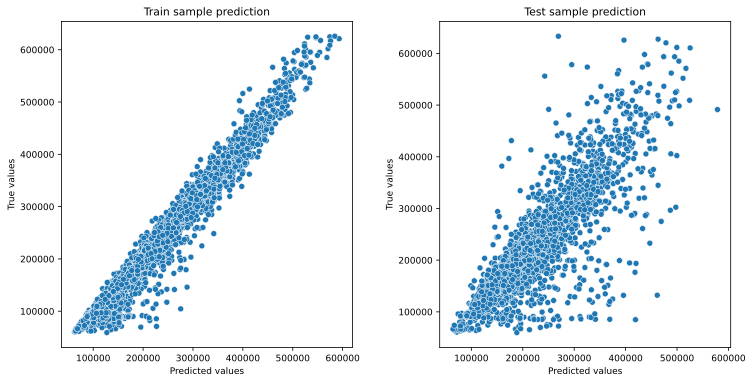

In [55]:
rf_y_train_preds = rf_model.predict(X_train)
rf_y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_train, rf_y_train_preds, y_test, rf_y_test_preds)

In [56]:
# Модель RandomForestRegressor дала хороший результат, на тренировочных данных 0,961 на тестовых 0,718.

In [57]:
#Проводим кросс-валидацию для оценки качества модели
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
#cv_score.mean()
cv_score.mean()

0.7179233677239508

In [58]:
# Смотрю значимость признаков
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['Feature names', 'Importance'])

feature_importances.sort_values(by='Importance', ascending=False)

Feature names  Importance
2          Square    0.281429
1           Rooms    0.166071
11       Social_1    0.104014
12       Social_2    0.067265
0      DistrictId    0.053966
13       Social_3    0.053083
4   KitchenSquare    0.044346
3      LifeSquare    0.042523
8       Ecology_1    0.040285
7       HouseYear    0.040151
6      HouseFloor    0.027875
14   Healthcare_1    0.026431
5           Floor    0.024855
16        Shops_1    0.016505
15    Helthcare_2    0.008617
17   Shops_2 _bin    0.001130
9   Ecology_2_bin    0.000748
10  Ecology_3_bin    0.000702

# Обучаем на LinearRegression и оцениваем модель.

In [59]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

Train R2:	0.456
Test R2:	0.46


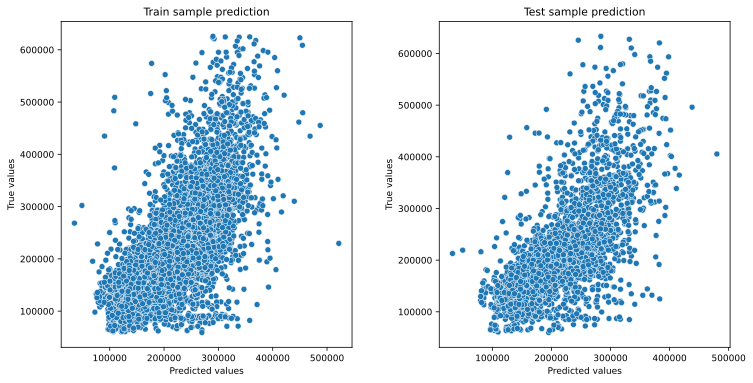

In [60]:
lr_y_train_preds = lr_model.predict(X_train)
lr_y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_train, lr_y_train_preds, y_test, lr_y_test_preds)

In [61]:
cv_score = cross_val_score(lr_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([ 0.45991222, -0.48521623, -0.08352148])

In [62]:
feature_importances = pd.DataFrame(zip(X_train.columns, lr_model.coef_), 
                                   columns=['Feature names', 'Importance'])

feature_importances.sort_values(by='Importance', ascending=False)

Feature names    Importance
1           Rooms  60753.247040
9   Ecology_2_bin  33374.488974
17   Shops_2 _bin  14601.384679
15    Helthcare_2   5148.717039
6      HouseFloor   1623.787607
5           Floor   1360.657086
11       Social_1    872.494199
2          Square    744.167915
0      DistrictId    415.143870
7       HouseYear    204.518308
13       Social_3     29.608330
14   Healthcare_1      7.005856
12       Social_2     -0.525595
16        Shops_1   -410.783495
4   KitchenSquare   -915.533925
3      LifeSquare   -918.063270
10  Ecology_3_bin -20297.972843
8       Ecology_1 -53060.124753

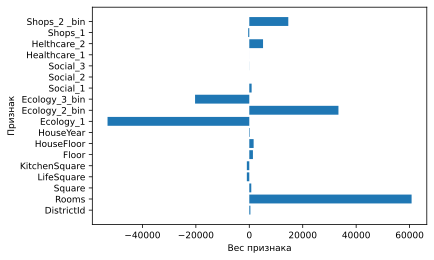

In [63]:
# Для наглядности визуализируем показатели признаков по весу.
plt.barh(feature_names, lr_model.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

In [64]:
# К сожалению модель Linear Regression не подходит, слишком плохой результат (Train R2:0.456, Test R2:0.461).
# Так же попробовала другие модели из этого же семейства, что и Linear Regression (Lasso и Ridge),они показали результат еще хуже.
# Оставила только эту.

# Обучаем на GradientBoostingRegressor и оцениваем модель.

In [65]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [66]:
gb_y_train_preds = gb_model.predict(X_train)
gb_y_test_preds = gb_model.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, gb_y_test_preds))
print('Mean Squared Error:', mean_squared_error(y_test, gb_y_test_preds))
print('R2 Score:', r2(y_test, gb_y_test_preds))

Mean Absolute Error: 32861.58192547602
Mean Squared Error: 2694660691.038723
R2 Score: 0.690525506288179


Train R2:	0.76
Test R2:	0.691


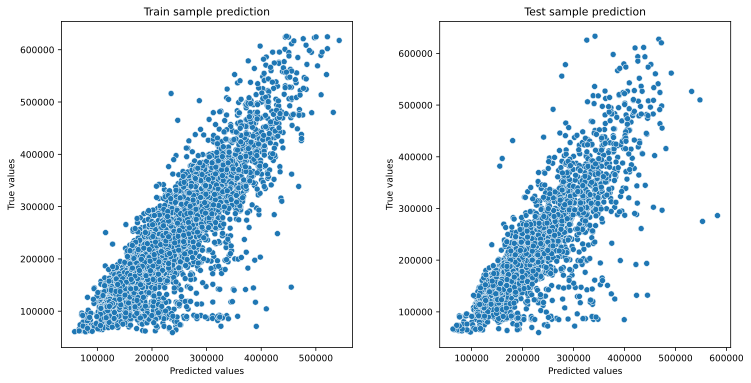

In [67]:
evaluate_preds(y_train, gb_y_train_preds, y_test, gb_y_test_preds)

In [68]:
cv_score = cross_val_score(gb_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score.mean()

0.6980816930322917

In [69]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['Feature names', 'Importance'])

feature_importances.sort_values(by='Importance', ascending=False)

Feature names  Importance
2          Square    0.330615
1           Rooms    0.179603
11       Social_1    0.115211
13       Social_3    0.077268
0      DistrictId    0.067320
12       Social_2    0.052536
8       Ecology_1    0.046034
4   KitchenSquare    0.040217
7       HouseYear    0.030982
14   Healthcare_1    0.021907
6      HouseFloor    0.018607
3      LifeSquare    0.006536
5           Floor    0.006159
16        Shops_1    0.005618
15    Helthcare_2    0.000740
9   Ecology_2_bin    0.000646
10  Ecology_3_bin    0.000000
17   Shops_2 _bin    0.000000

In [70]:
# Модель Gradient Boosting Regressor дала не такие плохие результаты как Linear Regression, но и не такие хорошие как RandomForestRegressor.  

    Модель Random Forest Regressor (Train R2: 0.961, Test R2: 0.718)
    Модель Gradient Boosting Regressor (Train R2: 0.759, Test R2: 0.687)
    Модель Linear Regression (Train R2:0.456, Test R2:0.461)
Вывод: Как наглядно видно из полученных мной результатов, наиболее подходящей моделью является Random Forest Regressor, 
на ней я и буду делать предсказание.

# Переходим к работе с тестовыми данными и предсказанию.

# Подготавливаем данные:

In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [72]:
# Меняем тип данных
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
test_df['HouseFloor'] = test_df['HouseFloor'].astype(int)

In [73]:
# Рассматриваем количественные признаки 
test_df.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  5000.000000  5000.000000  3959.000000    5000.000000  5000.000000   
mean      1.910000    56.449500    36.158810       5.976800     8.632000   
std       0.838594    19.092787    17.825287       9.950018     5.483228   
min       0.000000     1.378543     0.333490       0.000000     1.000000   
25%       1.000000    41.906231    23.092026       1.000000     4.000000   
50%       2.000000    52.921340    32.925087       6.000000     7.000000   
75%       2.000000    66.285129    45.174091       9.000000    12.000000   
max      17.000000   223.453689   303.071094     620.000000    78.000000   

        HouseFloor    HouseYear    Ecology_1     Social_1      Social_2  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean     12.601000  1984.392600     0.119874    24.933800   5406.900000   
std       6.789213    18.573149     0.120070    17.532202   4026.614773   
min       0.000000  1908.000000     0.000000     0.000000    168.000000   
25%       9.000000  1973.000000     0.019509     6.000000   1564.000000   
50%      12.000000  1977.000000     0.072158    25.000000   5285.000000   
75%      17.000000  2000.000000     0.195781    36.000000   7287.000000   
max      99.000000  2020.000000     0.521867    74.000000  19083.000000   

          Social_3  Healthcare_1  Helthcare_2      Shops_1  
count  5000.000000   2623.000000   5000.00000  5000.000000  
mean      8.262600   1146.657263      1.31940     4.242800  
std      23.863762   1044.744231      1.47994     4.777365  
min       0.000000      0.000000      0.00000     0.000000  
25%       0.000000    325.000000      0.00000     1.000000  
50%       2.000000    900.000000      1.00000     3.000000  
75%       5.000000   1548.000000      2.00000     6.000000  
max     141.000000   4849.000000      6.00000    23.000000

In [74]:
# Проверим есть ли аномалии в квартирах с 0 комнат(как в педидущем df)
test_df[test_df['Rooms'] == 0] #Просматриваем информацию по квартирам с 0 комнат.
# Нет. Все в приделах нормы, обрабатывать не буду. 

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
2406   3343         58    0.0  116.824201  113.692424            0.0      3   
2524  10729         27    0.0   76.345154   42.820796           12.0     14   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
2406           3       1977   0.437885         B         B        23   
2524           0       1977   0.017647         B         B         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
2406      5735         3        1084.0            0        5       B  
2524       469         0           NaN            0        0       B

In [75]:
# Также хочу рассмотреть уникальные значения по комната и проверить нет ли там выбросов.
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

In [76]:
test_df.loc[test_df['Rooms']== 17] # видно, что это аномальное значение, т.к при общей площади = 52.87 и жилой равной 32.53, 
# такое кол-во комнат странно.

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
3398  1435        111   17.0  52.866107   32.528342            8.0     15   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
3398          17       1987   0.093443         B         B        23   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
3398      4635         5        3300.0            2        4       B

In [77]:
# Обрабатываем эту аномалию.
# я буду заменять колличество комнат в этой квартире средним значением комнат, выбранных из краврир с похожей площадью. 
test_df.loc[test_df['Rooms'] == 17, 'Rooms'] = int(test_df.loc[(test_df['Square'].between(51,56,inclusive=True)), 'Rooms'].mean())
test_df.iloc[[3398]]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
3398  1435        111    1.0  52.866107   32.528342            8.0     15   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
3398          17       1987   0.093443         B         B        23   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
3398      4635         5        3300.0            2        4       B

In [78]:
#Смотрим есть ли у нас аномалии с годами постройки, конкретно в этом случаи есть ли дома из будущего. 
test_df.sort_values(by='HouseYear', ascending=True) #На первый взгляд все хорошо

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
3253  12316        183    5.0  157.976101  101.040485           12.0      7   
2      5480        190    1.0   13.597819   15.948246           12.0      2   
2691   9076         60    3.0   61.400464   38.591813            8.0      5   
64     3726        161    1.0   52.708494   20.502345           11.0      3   
1475  16217        206    4.0   76.428426   50.344903           11.0      7   
...     ...        ...    ...         ...         ...            ...    ...   
1039   4696         59    2.0   75.577646   41.758328           15.0      8   
3255   9398         58    2.0   70.999008         NaN           17.0     13   
888    8560         37    2.0   57.979074         NaN           10.0      7   
4273   8311         53    1.0   38.747897   21.602020            8.0     15   
4389   2359         53    2.0   60.734498   42.793561           10.0     17   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
3253           8       1908   0.246624         B         B        14   
2              5       1909   0.000000         B         B        30   
2691           5       1910   0.341072         B         B        27   
64             7       1911   0.014423         B         B        19   
1475           6       1912   0.042032         B         B        37   
...          ...        ...        ...       ...       ...       ...   
1039          20       2020   0.019509         B         B        37   
3255          15       2020   0.437885         B         B        23   
888           20       2020   0.178917         B         B        18   
4273          24       2020   0.049637         B         B        34   
4389          24       2020   0.049637         B         B        34   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
3253      2940        45           NaN            3        6       B  
2         7538        87        4702.0            5        5       B  
2691      5664        48        2300.0            3       11       B  
64        3806         4           NaN            0        3       B  
1475      6856        84        1940.0            2        5       B  
...        ...       ...           ...          ...      ...     ...  
1039      7687        11         176.0            5        5       B  
3255      5735         3        1084.0            0        5       B  
888       3594         4         192.0            1        5       B  
4273      7759         0         229.0            1        3       B  
4389      7759         0         229.0            1        3       B  

[5000 rows x 19 columns]

In [79]:
test_df['HouseYear'].describe() # Пререправерим через функцию дескрайб. Да, все хорошо самый старый дом построен в 1908, а молодой в 2020.
# Это в приделах нормы

count    5000.000000
mean     1984.392600
std        18.573149
min      1908.000000
25%      1973.000000
50%      1977.000000
75%      2000.000000
max      2020.000000
Name: HouseYear, dtype: float64

In [80]:
# Теперь площадь. Смотрим среднюю разность между общей площадью квартиры и жилой + кухня
difference = test_df.loc[test_df['Square'] >= (test_df['LifeSquare'] + test_df['KitchenSquare']), 'Square'] - test_df.loc[test_df['LifeSquare'] > 0, 'LifeSquare'] - test_df['KitchenSquare']
difference.describe()

count    3521.000000
mean       14.580838
std        11.576145
min         0.014635
25%         8.943116
50%        12.189998
75%        16.705751
max       134.899280
dtype: float64

In [81]:
# Считаем средний процент нежилой площади от общей. Буду использовать уже сделанную в train формулу.
valid_square = test_df.loc[test_df['Square'] >= (test_df['LifeSquare'] + test_df['KitchenSquare']), 'Square']#находим только те квартиры где общая площадь больше или равна жилой + кухня
mean_diff = (difference / (valid_square / 100)).mean() # из полученных выше данных получаем средний процент нежилой площади 
mean_diff

25.813834746134894

In [82]:
# заменяем все значения NaN по формуле общая площадь - кухня - не жилая площадь .
test_df.loc[test_df['LifeSquare'].isnull(),'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare'] - ((test_df['Square'] / 100) * mean_diff)
test_df.info() # проверяем, что значений NaN в df не осталось.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   int32  
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [83]:
# Теперь находим и записываем индексы квартир с аномальной площадью
Square_outliers = test_df.loc[test_df['Square'] < (test_df['LifeSquare'] + test_df['KitchenSquare'])].index
Square_outliers

Int64Index([   2,   27,   29,   39,   43,   45,   55,   66,   70,  102,
            ...
            4902, 4914, 4927, 4947, 4951, 4962, 4967, 4969, 4974, 4979],
           dtype='int64', length=438)

In [84]:
# Заменяем аномальные значения. Вычитаем общую площадь квартиры (жилая площадь + кухня + не жилая площадь)
test_df.loc[Square_outliers, 'Square'] = test_df['LifeSquare'] + test_df['KitchenSquare'] + (((test_df['LifeSquare'] + test_df['KitchenSquare']) / 100) * mean_diff)

# Проверяем, что аномалии заменены. Используем те же критерии для поиска аномалий, что и выше.
Square_outliers_updated = test_df.loc[test_df['Square'] < (test_df['LifeSquare'] + test_df['KitchenSquare'])].index
Square_outliers_updated 
# Список получился пустой, все аномалии заменены.

Int64Index([], dtype='int64')

In [85]:
# Теперь этажность.
# Смотрим уникальные значения этажей дома
test_df['HouseFloor'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37, 39, 40, 48, 99])

In [86]:
# Смотрим уникальные значения этажей квартир в доме
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

In [87]:
# Обрабатываем аномальную этажность дома, убираем значения выше 78.
test_df.loc[test_df['HouseFloor'] > 78,'HouseFloor'] = test_df['HouseFloor'].median()
test_df['HouseFloor'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37, 39, 40, 48])

In [88]:
# Смотрим есть ли у нас дома с 0 этажностью
test_df.loc[test_df['HouseFloor'] == 0,'HouseFloor']

22      0
24      0
30      0
32      0
46      0
       ..
4856    0
4887    0
4892    0
4976    0
4998    0
Name: HouseFloor, Length: 131, dtype: int32

In [89]:
# Замееняем дома с нулевой этажностью на этаж квартиры находящийся в этом доме
test_df.loc[test_df['HouseFloor'] == 0,'HouseFloor'] = test_df['Floor']

# Проверяем, что домов с 0 этажностью не осталось.
test_df.loc[test_df['HouseFloor'] == 0,'HouseFloor']

Series([], Name: HouseFloor, dtype: int64)

In [90]:
# Смотрим есть ли у нас дом, где этаж квартиры больше этажности дома и записываем их индексы
Floor_outliers = test_df.loc[test_df['HouseFloor'] < test_df['Floor']].index
Floor_outliers

Int64Index([   1,   10,   14,   27,   36,   41,   55,   58,   59,   65,
            ...
            4956, 4957, 4958, 4962, 4964, 4968, 4972, 4989, 4993, 4997],
           dtype='int64', length=754)

In [91]:
# Заменяем аномальные(по этажности) квартиры.
test_df.loc[Floor_outliers, 'Floor'] = test_df.loc[Floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x)) 

# Проверяем, что квартир с аномалией не осталось
Floor_outliers_updated = test_df.loc[test_df['HouseFloor'] < test_df['Floor']].index
Floor_outliers_updated

Int64Index([], dtype='int64')

In [92]:
# и опять сравниваем между собой списки, что бы убедиться, что аномалий не осталось. 

In [93]:
test_df['HouseFloor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       36, 37, 39, 40, 48], dtype=int64)

In [94]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 38, 46],
      dtype=int64)

In [95]:
# Обрабатываем пропуски в признаке Healthcare_1, заменяем пропуски на медиану.
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df.loc[test_df['Healthcare_1'].notnull(), 'Healthcare_1'].median()

# Проверяем, что пропусков нет.
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   int64  
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [96]:
# Обрабатываем катигариальные признаки. 
# Создаем на основе катигариальных признаков новые, которые потом будем использовать в обучении модели.
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2 _bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   int64  
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [97]:
# Тут создавать новые признаки я не буду, как показала практика выбранная мною, для обучения модель, лучше работает без них.

In [98]:
# Так как модель RandomForestRegressor показала наилучший результат и она уже обученна на предведуших данных(поэтому тут их не дублирую) с помощъю нее и будем делать предсказание
X_test = test_df[feature_names]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   object 
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   int64  
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2_bin  5000 non-null   int64  
 10  Ecology_3_bin  5000 non-null   int64  
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   5000 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2 _bin   5000 non-null   int64  
dtypes: float

In [99]:
# Подаю данные в уже обученную модель(выше) для предсказания 
y_test_pred = rf_model.predict(X_test)

In [100]:
test_df['Price'] = y_test_pred
test_df

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0       725         58    2.0  49.882643   33.432782            6.0      6   
1     15856         74    2.0  69.263183   50.383700            1.0      1   
2      5480        190    1.0  35.162761   15.948246           12.0      2   
3     15664         47    2.0  73.046609   51.940842            9.0     22   
4     14275         27    1.0  47.527111   43.387569            1.0     17   
...     ...        ...    ...        ...         ...            ...    ...   
4995   8180         11    3.0  67.133911   50.809797            6.0      5   
4996   4695          1    1.0  40.198472   21.807061           10.0     12   
4997   5783         12    3.0  77.842178   48.282625            9.0     21   
4998   4780         62    2.0  81.305222   60.317226            0.0      4   
4999  12504         30    2.0  60.555693   43.923946            1.0     10   

      HouseFloor  HouseYear  Ecology_1  ... Social_2 Social_3  Healthcare_1  \
0             14       1972   0.310199  ...     2748        1         900.0   
1              1       1977   0.075779  ...     1437        3         900.0   
2              5       1909   0.000000  ...     7538       87        4702.0   
3             22       2007   0.101872  ...     4583        3         900.0   
4             17       2017   0.072158  ...      629        1         900.0   
...          ...        ...        ...  ...      ...      ...           ...   
4995           9       1973   0.000170  ...     5992        0         900.0   
4996          17       2017   0.007122  ...      264        0         900.0   
4997          22       1989   0.090799  ...    19083        2         900.0   
4998           4       1977   0.072158  ...      629        1         900.0   
4999          17       1977   0.000078  ...     6398      141        1046.0   

      Helthcare_2  Shops_1  Shops_2  Ecology_2_bin  Ecology_3_bin  \
0               0        0        B              1              1   
1               0        2        B              1              1   
2               5        5        B              1              1   
3               3        3        B              1              1   
4               0        0        A              1              1   
...           ...      ...      ...            ...            ...   
4995            1        1        B              1              1   
4996            0        1        B              1              1   
4997            5       15        B              1              1   
4998            0        0        A              1              1   
4999            3       23        B              1              1   

     Shops_2 _bin          Price  
0               1  167488.036601  
1               1  208327.666340  
2               1  263210.420457  
3               1  331865.827401  
4               0  143364.015767  
...           ...            ...  
4995            1  242253.133144  
4996            1  132406.994906  
4997            1  338046.079637  
4998            0  192777.098192  
4999            1  159720.868233  

[5000 rows x 23 columns]

In [101]:

pd.DataFrame({ 'Id': test_df['Id'], 'Price': test_df['Price']}).to_csv('TV_PRED_PRICE.csv', index=False)

In [102]:
# P.S.  Функцию на проверку скорости выполнения не прописывала, так как весь файл (полностью) отрабатывает меньше чем за 1,5 минуты.